In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime, timedelta
import warnings

from sklearn.linear_model import LinearRegression
import yfinance as yf

[*********************100%%**********************]  1 of 1 completed

                Close
Date                 
2020-06-01  45.110001
2020-06-02  45.220001
2020-06-03  45.740002
2020-06-04  45.009998
2020-06-05  45.759998
...               ...
2024-04-03  80.519997
2024-04-04  78.790001
2024-04-05  79.550003
2024-04-08  78.779999
2024-04-09  78.540001

[971 rows x 1 columns]


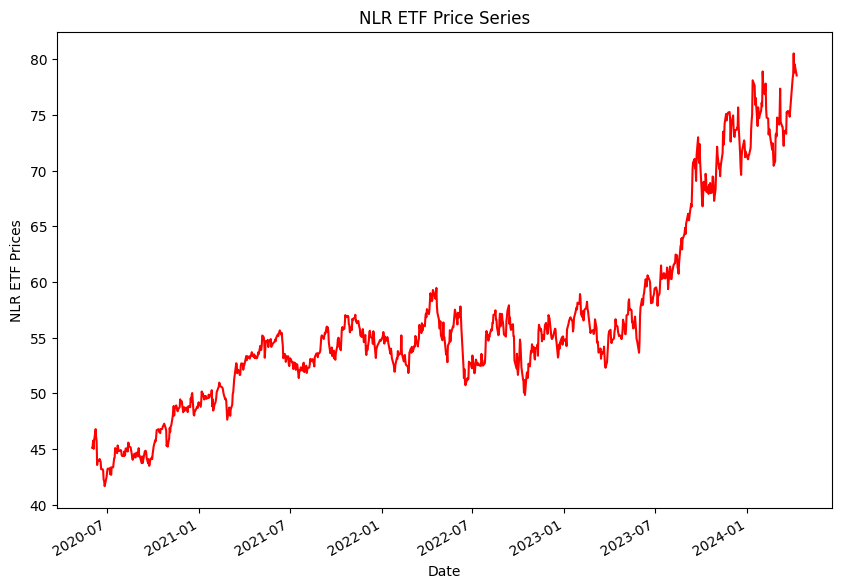

In [2]:
# machine learning linear regression
df = yf.download('NLR', '2020-06-01', '2024-04-10')
df = df[['Close']]

print(df)

# only keep closing price
df = df.dropna()
df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("NLR ETF Prices")
plt.title("NLR ETF Price Series")
plt.show()

In [3]:
# train: use moving averages over last 3 days and 9 days 
df['S_3'] = df['Close'].rolling(window=3).mean()
df['S_9'] = df['Close'].rolling(window=9).mean()
df['next_day_price'] = df['Close'].shift(-1)

df = df.dropna()
x = df[['S_3', 'S_9']]

y = df['next_day_price']

# separate testing and training data
index = int(0.8*(len(df)))
x_train, x_test, y_train, y_test = x[:index], x[index:], y[:index], y[index:]

# train linear regression
linear = LinearRegression().fit(x_train, y_train)

print("Linear Regression model")
print("NLR ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
NLR ETF Price (y) = 1.12 * 3 Days Moving Average (x1) + -0.14 * 9 Days Moving Average (x2) + 0.91 (constant)


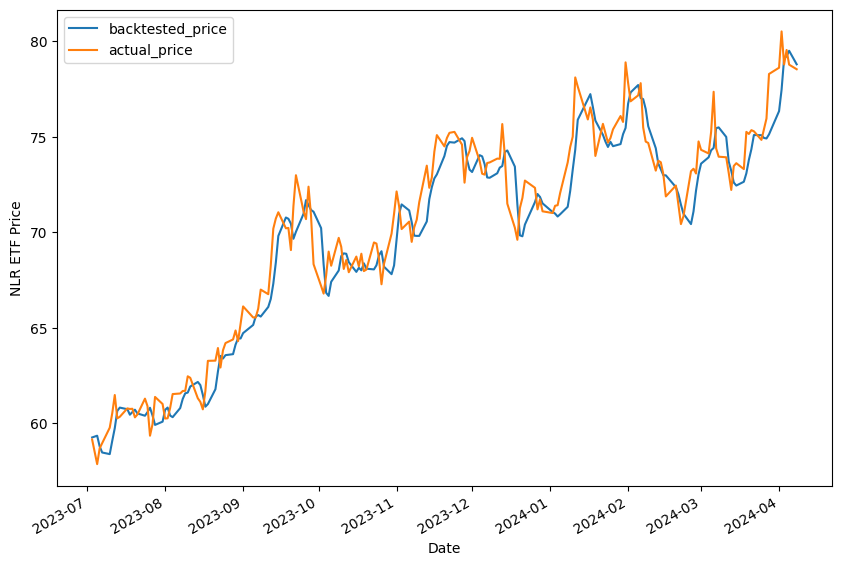

                price
Date                 
2023-07-03  59.257744
2023-07-05  59.349157
2023-07-06  58.786400
2023-07-07  58.469651
2023-07-10  58.385735
...               ...
2024-04-02  77.465915
2024-04-03  79.092537
2024-04-04  79.222857
2024-04-05  79.505561
2024-04-08  78.798671

[193 rows x 1 columns]


In [4]:
# backtest: predict NLR ETF price in test data
backtest_price = linear.predict(x_test)
backtest_price = pd.DataFrame(
    backtest_price, index=y_test.index, columns=['price'])
backtest_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['backtested_price', 'actual_price'])
plt.ylabel("NLR ETF Price")
plt.show()

print(backtest_price)
# export to excel
export_df = pd.DataFrame({
    'dates': x_test.index,  # Assuming index contains dates
    'actual_price': y_test,
    'backtested_price': backtest_price['price']  # Assuming 'shuffle_predicted_price' is already defined
})

# Export the DataFrame to an Excel file
# export_df.to_excel('NLR_backtest_results.xlsx', index=False)

In [5]:
# predict next three months of results
# generate dates
start_date = datetime(2024, 4, 10)
end_date = datetime(2024, 7, 31)


# load original data
df = yf.download('NLR', '2020-06-01', '2024-04-10')
df = df[['Close']]
df = df.dropna()
df['S_3'] = df['Close'].rolling(window=3).mean()
df['S_9'] = df['Close'].rolling(window=9).mean()
df = df.dropna()

current_date = df.index[-1]
end_date = datetime(2024, 7, 31)

print("original df")
print(df)
while current_date <= end_date:
    # forecast the price
    df['predicted_price'] = linear.predict(df[['S_3', 'S_9']])
    last_row = df.tail(1)
    predicted_nlr_price = last_row['predicted_price'].iloc[-1]
    # print("predicted price: ", predicted_nlr_price)
    # print("after calculating predicted price")
    # print(df)

    last_date = df.index[-1]
    new_date = last_date + timedelta(days=1)
    current_date = new_date
    new_row = pd.DataFrame(index=[new_date], columns=df.columns)
    new_row['Close'] = predicted_nlr_price
    moving_avg_list = df['Close'].iloc[-8:].tolist()
    moving_avg_list.append(predicted_nlr_price)
    new_row['S_3'] = sum(moving_avg_list[-3:]) / 3
    new_row['S_9'] = sum(moving_avg_list) / 9
    warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.*")
    df = pd.concat([df, new_row])   
    # print("after adding new row")
    # print(df)

# adjust to only weekly data 
df = df.resample('W-FRI').last() # only weekly data 
# export to excel
export_df = pd.DataFrame({
    'dates': df.index,  
    'predicted_price': df['predicted_price'],
    'actual_price': df['Close'],
    'S_3': df['S_3'],
    'S_9': df['S_9']
})

# Export the DataFrame to an Excel file
export_df.to_excel('NLR_predicted_full_results.xlsx', index=False)

[*********************100%%**********************]  1 of 1 completed

original df
                Close        S_3        S_9
Date                                       
2020-06-11  43.560001  45.110001  45.438889
2020-06-12  43.939999  44.400000  45.308889
2020-06-15  43.950001  43.816667  45.167778
2020-06-16  44.099998  43.996666  44.985555
2020-06-17  43.959999  44.003333  44.868888
...               ...        ...        ...
2024-04-03  80.519997  79.143333  76.603333
2024-04-04  78.790001  79.310000  77.007778
2024-04-05  79.550003  79.620000  77.474445
2024-04-08  78.779999  79.040001  77.862222
2024-04-09  78.540001  78.956668  78.273334

[963 rows x 3 columns]


In [6]:
# helper functions and structures

def extract_column(csv_file, column_index, col_type):
    column_values = []
    months = ['','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    with open(csv_file, 'r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader) # skip header row
        for row in csv_reader:
            if len(row) > column_index:
                if (col_type == 'date'):
                    date = row[column_index].split('-')
                    if (len(date) == 3):
                        year = str(date[0])
                        month = months[int(date[1]) - 1]
                        column_values.append(month + year)
                elif (col_type == 'data'):
                    column_values.append(row[column_index])
                    
    return column_values